# Comet MLfrom comet_ml import Experiment

In [ ]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [ ]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [ ]:
# experiment.log_parameters(hyper_params)

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [4]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id_x)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [6]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-4.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)
data_val = BoneAgeDataset("boneage-validation-4.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
# val_size = int(len(data_train) * 0.2)
# train_size = len(data_train) - (val_size)

# train_set, val_set = random_split(
#     data_train,
#     [train_size, val_size]
# )

trainloader = DataLoader(data_train, batch_size=bs)
valloader = DataLoader(data_val, batch_size=bs)

In [7]:
len(data_train), len(data_val)

(48597, 12160)

# Architecture and Config

In [8]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [9]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [10]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [11]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [12]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [13]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [14]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [15]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [16]:
!mkdir Model-4

In [17]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-4/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [18]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/760 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 190/190 [01:09<00:00,  2.75it/s, Epoch=1, LR=6.58e-5, Valid_Loss=24.6]


Valid RMSE: 24.85027503967285
Valid MAE: 19.671878814697266
Valid SMAPE: 0.17178158462047577
Validation Loss Improved (inf ---> 24.85027503967285)



100%|██████████| 190/190 [00:59<00:00,  3.21it/s, Epoch=2, LR=1.05e-5, Valid_Loss=20.3]


Valid RMSE: 20.566722869873047
Valid MAE: 15.980779647827148
Valid SMAPE: 0.1409587562084198
Validation Loss Improved (24.85027503967285 ---> 20.566722869873047)



100%|██████████| 190/190 [00:57<00:00,  3.29it/s, Epoch=3, LR=1.05e-5, Valid_Loss=19.7]


Valid RMSE: 19.854248046875
Valid MAE: 15.370096206665039
Valid SMAPE: 0.1362559050321579
Validation Loss Improved (20.566722869873047 ---> 19.854248046875)



100%|██████████| 190/190 [01:00<00:00,  3.13it/s, Epoch=4, LR=6.58e-5, Valid_Loss=19.6]


Valid RMSE: 19.81236457824707
Valid MAE: 15.259917259216309
Valid SMAPE: 0.13518863916397095
Validation Loss Improved (19.854248046875 ---> 19.81236457824707)



100%|██████████| 190/190 [01:11<00:00,  2.64it/s, Epoch=5, LR=0.0001, Valid_Loss=20.5]


Valid RMSE: 20.811513900756836
Valid MAE: 15.91602611541748
Valid SMAPE: 0.14072929322719574



100%|██████████| 190/190 [01:16<00:00,  2.48it/s, Epoch=6, LR=6.58e-5, Valid_Loss=18.9]


Valid RMSE: 19.12771224975586
Valid MAE: 14.784019470214844
Valid SMAPE: 0.1316618174314499
Validation Loss Improved (19.81236457824707 ---> 19.12771224975586)



100%|██████████| 190/190 [01:14<00:00,  2.55it/s, Epoch=7, LR=1.05e-5, Valid_Loss=18.6]


Valid RMSE: 18.75992774963379
Valid MAE: 14.542125701904297
Valid SMAPE: 0.12840712070465088
Validation Loss Improved (19.12771224975586 ---> 18.75992774963379)



100%|██████████| 190/190 [01:00<00:00,  3.12it/s, Epoch=8, LR=1.05e-5, Valid_Loss=18.5]


Valid RMSE: 18.677085876464844
Valid MAE: 14.374760627746582
Valid SMAPE: 0.12763948738574982
Validation Loss Improved (18.75992774963379 ---> 18.677085876464844)



100%|██████████| 190/190 [01:01<00:00,  3.10it/s, Epoch=9, LR=6.58e-5, Valid_Loss=19.5]


Valid RMSE: 19.700191497802734
Valid MAE: 15.21442699432373
Valid SMAPE: 0.13458631932735443



100%|██████████| 190/190 [00:57<00:00,  3.31it/s, Epoch=10, LR=0.0001, Valid_Loss=18.6]


Valid RMSE: 18.832523345947266
Valid MAE: 14.45402717590332
Valid SMAPE: 0.12921135127544403



100%|██████████| 190/190 [01:02<00:00,  3.03it/s, Epoch=11, LR=6.58e-5, Valid_Loss=17.6]


Valid RMSE: 17.80731964111328
Valid MAE: 13.734070777893066
Valid SMAPE: 0.12237424403429031
Validation Loss Improved (18.677085876464844 ---> 17.80731964111328)



100%|██████████| 190/190 [01:06<00:00,  2.87it/s, Epoch=12, LR=1.05e-5, Valid_Loss=17.9]


Valid RMSE: 18.126344680786133
Valid MAE: 13.968073844909668
Valid SMAPE: 0.12373748421669006



100%|██████████| 190/190 [00:59<00:00,  3.21it/s, Epoch=13, LR=1.05e-5, Valid_Loss=17.2]


Valid RMSE: 17.438350677490234
Valid MAE: 13.519004821777344
Valid SMAPE: 0.11999298632144928
Validation Loss Improved (17.80731964111328 ---> 17.438350677490234)



100%|██████████| 190/190 [00:56<00:00,  3.39it/s, Epoch=14, LR=6.58e-5, Valid_Loss=18.1]


Valid RMSE: 18.349376678466797
Valid MAE: 14.0968017578125
Valid SMAPE: 0.12565048038959503



100%|██████████| 190/190 [00:53<00:00,  3.52it/s, Epoch=15, LR=0.0001, Valid_Loss=17.8]


Valid RMSE: 17.98598289489746
Valid MAE: 13.880322456359863
Valid SMAPE: 0.1238776370882988



100%|██████████| 190/190 [01:19<00:00,  2.39it/s, Epoch=16, LR=6.58e-5, Valid_Loss=17.2]


Valid RMSE: 17.380138397216797
Valid MAE: 13.481216430664062
Valid SMAPE: 0.11950548738241196
Validation Loss Improved (17.438350677490234 ---> 17.380138397216797)



100%|██████████| 190/190 [01:04<00:00,  2.97it/s, Epoch=17, LR=1.05e-5, Valid_Loss=17]  


Valid RMSE: 17.197784423828125
Valid MAE: 13.282523155212402
Valid SMAPE: 0.11745601147413254
Validation Loss Improved (17.380138397216797 ---> 17.197784423828125)



100%|██████████| 190/190 [00:58<00:00,  3.27it/s, Epoch=18, LR=1.05e-5, Valid_Loss=17.4]


Valid RMSE: 17.61522674560547
Valid MAE: 13.479108810424805
Valid SMAPE: 0.1203409880399704



100%|██████████| 190/190 [00:53<00:00,  3.53it/s, Epoch=19, LR=6.58e-5, Valid_Loss=17.3]


Valid RMSE: 17.474468231201172
Valid MAE: 13.42914867401123
Valid SMAPE: 0.11973685026168823



100%|██████████| 190/190 [01:01<00:00,  3.09it/s, Epoch=20, LR=0.0001, Valid_Loss=18.3]


Valid RMSE: 18.538145065307617
Valid MAE: 14.332707405090332
Valid SMAPE: 0.12790542840957642



100%|██████████| 190/190 [01:01<00:00,  3.06it/s, Epoch=21, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.056406021118164
Valid MAE: 13.123994827270508
Valid SMAPE: 0.11706430464982986
Validation Loss Improved (17.197784423828125 ---> 17.056406021118164)



100%|██████████| 190/190 [01:09<00:00,  2.72it/s, Epoch=22, LR=1.05e-5, Valid_Loss=17.1]


Valid RMSE: 17.31230354309082
Valid MAE: 13.314586639404297
Valid SMAPE: 0.11812332272529602



100%|██████████| 190/190 [00:59<00:00,  3.20it/s, Epoch=23, LR=1.05e-5, Valid_Loss=16.3]


Valid RMSE: 16.526243209838867
Valid MAE: 12.727682113647461
Valid SMAPE: 0.11341236531734467
Validation Loss Improved (17.056406021118164 ---> 16.526243209838867)



100%|██████████| 190/190 [00:55<00:00,  3.45it/s, Epoch=24, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.13238525390625
Valid MAE: 13.13290786743164
Valid SMAPE: 0.11742684990167618



100%|██████████| 190/190 [01:03<00:00,  3.00it/s, Epoch=25, LR=0.0001, Valid_Loss=17.6]


Valid RMSE: 17.840717315673828
Valid MAE: 13.625121116638184
Valid SMAPE: 0.12007180601358414



100%|██████████| 190/190 [00:57<00:00,  3.32it/s, Epoch=26, LR=6.58e-5, Valid_Loss=16.7]


Valid RMSE: 16.93355369567871
Valid MAE: 13.031380653381348
Valid SMAPE: 0.11686805635690689



100%|██████████| 190/190 [01:01<00:00,  3.07it/s, Epoch=27, LR=1.05e-5, Valid_Loss=17.1]


Valid RMSE: 17.311717987060547
Valid MAE: 13.21434497833252
Valid SMAPE: 0.11733798682689667



100%|██████████| 190/190 [00:58<00:00,  3.25it/s, Epoch=28, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.724445343017578
Valid MAE: 12.898008346557617
Valid SMAPE: 0.11501413583755493



100%|██████████| 190/190 [01:03<00:00,  2.99it/s, Epoch=29, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.098905563354492
Valid MAE: 13.070271492004395
Valid SMAPE: 0.11644502729177475



100%|██████████| 190/190 [00:55<00:00,  3.44it/s, Epoch=30, LR=0.0001, Valid_Loss=17.1]


Valid RMSE: 17.337764739990234
Valid MAE: 13.349398612976074
Valid SMAPE: 0.11869639158248901



100%|██████████| 190/190 [01:07<00:00,  2.80it/s, Epoch=31, LR=6.58e-5, Valid_Loss=16.4]


Valid RMSE: 16.586454391479492
Valid MAE: 12.76791763305664
Valid SMAPE: 0.11328472197055817



100%|██████████| 190/190 [00:57<00:00,  3.30it/s, Epoch=32, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.65636444091797
Valid MAE: 12.778569221496582
Valid SMAPE: 0.11405850201845169



100%|██████████| 190/190 [01:10<00:00,  2.71it/s, Epoch=33, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.714534759521484
Valid MAE: 12.857152938842773
Valid SMAPE: 0.1152370423078537



100%|██████████| 190/190 [00:54<00:00,  3.48it/s, Epoch=34, LR=6.58e-5, Valid_Loss=16.4]


Valid RMSE: 16.59229850769043
Valid MAE: 12.702296257019043
Valid SMAPE: 0.11296569555997849



100%|██████████| 190/190 [01:12<00:00,  2.63it/s, Epoch=35, LR=0.0001, Valid_Loss=16.9]


Valid RMSE: 17.15261459350586
Valid MAE: 13.188802719116211
Valid SMAPE: 0.11806793510913849



100%|██████████| 190/190 [00:56<00:00,  3.35it/s, Epoch=36, LR=6.58e-5, Valid_Loss=15.9]


Valid RMSE: 16.12682342529297
Valid MAE: 12.411310195922852
Valid SMAPE: 0.11072168499231339
Validation Loss Improved (16.526243209838867 ---> 16.12682342529297)



100%|██████████| 190/190 [00:59<00:00,  3.18it/s, Epoch=37, LR=1.05e-5, Valid_Loss=16.5]


Valid RMSE: 16.681922912597656
Valid MAE: 12.704484939575195
Valid SMAPE: 0.11293749511241913



100%|██████████| 190/190 [01:18<00:00,  2.41it/s, Epoch=38, LR=1.05e-5, Valid_Loss=16]  


Valid RMSE: 16.240787506103516
Valid MAE: 12.488565444946289
Valid SMAPE: 0.1124843880534172



100%|██████████| 190/190 [00:56<00:00,  3.39it/s, Epoch=39, LR=6.58e-5, Valid_Loss=16.9]


Valid RMSE: 17.081178665161133
Valid MAE: 12.952628135681152
Valid SMAPE: 0.11474345624446869



100%|██████████| 190/190 [01:09<00:00,  2.73it/s, Epoch=40, LR=0.0001, Valid_Loss=17.2]


Valid RMSE: 17.435588836669922
Valid MAE: 13.387883186340332
Valid SMAPE: 0.11881501227617264



100%|██████████| 190/190 [00:54<00:00,  3.50it/s, Epoch=41, LR=6.58e-5, Valid_Loss=16.3]


Valid RMSE: 16.48448944091797
Valid MAE: 12.614946365356445
Valid SMAPE: 0.11195558309555054



100%|██████████| 190/190 [00:53<00:00,  3.56it/s, Epoch=42, LR=1.05e-5, Valid_Loss=16.2]


Valid RMSE: 16.404052734375
Valid MAE: 12.527888298034668
Valid SMAPE: 0.11123962700366974



100%|██████████| 190/190 [00:52<00:00,  3.61it/s, Epoch=43, LR=1.05e-5, Valid_Loss=16]  


Valid RMSE: 16.220361709594727
Valid MAE: 12.363036155700684
Valid SMAPE: 0.11015114933252335



100%|██████████| 190/190 [00:56<00:00,  3.35it/s, Epoch=44, LR=6.58e-5, Valid_Loss=16.7]


Valid RMSE: 16.91594696044922
Valid MAE: 12.818169593811035
Valid SMAPE: 0.1149778887629509



100%|██████████| 190/190 [00:49<00:00,  3.86it/s, Epoch=45, LR=0.0001, Valid_Loss=16.9]


Valid RMSE: 17.123031616210938
Valid MAE: 12.95071792602539
Valid SMAPE: 0.11601098626852036



100%|██████████| 190/190 [01:03<00:00,  2.99it/s, Epoch=46, LR=6.58e-5, Valid_Loss=15.9]


Valid RMSE: 16.070497512817383
Valid MAE: 12.3068208694458
Valid SMAPE: 0.11018340289592743
Validation Loss Improved (16.12682342529297 ---> 16.070497512817383)



100%|██████████| 190/190 [01:01<00:00,  3.10it/s, Epoch=47, LR=1.05e-5, Valid_Loss=15.9]


Valid RMSE: 16.125213623046875
Valid MAE: 12.393061637878418
Valid SMAPE: 0.11062216758728027



100%|██████████| 190/190 [01:01<00:00,  3.09it/s, Epoch=48, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.780477523803711
Valid MAE: 12.196769714355469
Valid SMAPE: 0.10917501151561737
Validation Loss Improved (16.070497512817383 ---> 15.780477523803711)



100%|██████████| 190/190 [00:49<00:00,  3.84it/s, Epoch=49, LR=6.58e-5, Valid_Loss=16.4]


Valid RMSE: 16.558446884155273
Valid MAE: 12.589566230773926
Valid SMAPE: 0.11229978501796722



100%|██████████| 190/190 [01:01<00:00,  3.07it/s, Epoch=50, LR=0.0001, Valid_Loss=16.4]


Valid RMSE: 16.648601531982422
Valid MAE: 12.684086799621582
Valid SMAPE: 0.11312787979841232



100%|██████████| 190/190 [00:54<00:00,  3.48it/s, Epoch=51, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 16.010347366333008
Valid MAE: 12.170125007629395
Valid SMAPE: 0.10879770666360855



100%|██████████| 190/190 [00:54<00:00,  3.48it/s, Epoch=52, LR=1.05e-5, Valid_Loss=15.8]


Valid RMSE: 16.004440307617188
Valid MAE: 12.281095504760742
Valid SMAPE: 0.10962755233049393



100%|██████████| 190/190 [00:55<00:00,  3.45it/s, Epoch=53, LR=1.05e-5, Valid_Loss=15.8]


Valid RMSE: 16.034574508666992
Valid MAE: 12.31119441986084
Valid SMAPE: 0.11017771065235138



100%|██████████| 190/190 [00:52<00:00,  3.60it/s, Epoch=54, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.970932006835938
Valid MAE: 12.14183521270752
Valid SMAPE: 0.10855813324451447



100%|██████████| 190/190 [00:58<00:00,  3.26it/s, Epoch=55, LR=0.0001, Valid_Loss=16.4]


Valid RMSE: 16.64603042602539
Valid MAE: 12.639013290405273
Valid SMAPE: 0.11222108453512192



100%|██████████| 190/190 [00:56<00:00,  3.39it/s, Epoch=56, LR=6.58e-5, Valid_Loss=16]  


Valid RMSE: 16.237579345703125
Valid MAE: 12.377038955688477
Valid SMAPE: 0.11069956421852112



100%|██████████| 190/190 [00:50<00:00,  3.77it/s, Epoch=57, LR=1.05e-5, Valid_Loss=15.8]


Valid RMSE: 15.952296257019043
Valid MAE: 12.232269287109375
Valid SMAPE: 0.10880155861377716



100%|██████████| 190/190 [00:51<00:00,  3.66it/s, Epoch=58, LR=1.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.792012214660645
Valid MAE: 12.003003120422363
Valid SMAPE: 0.1077643558382988



100%|██████████| 190/190 [00:55<00:00,  3.42it/s, Epoch=59, LR=6.58e-5, Valid_Loss=15.9]


Valid RMSE: 16.09811782836914
Valid MAE: 12.185197830200195
Valid SMAPE: 0.10932402312755585



100%|██████████| 190/190 [00:53<00:00,  3.58it/s, Epoch=60, LR=0.0001, Valid_Loss=15.8]


Valid RMSE: 16.07267189025879
Valid MAE: 12.235843658447266
Valid SMAPE: 0.10997697710990906



100%|██████████| 190/190 [01:07<00:00,  2.82it/s, Epoch=61, LR=6.58e-5, Valid_Loss=15.7]


Valid RMSE: 15.897831916809082
Valid MAE: 12.16039752960205
Valid SMAPE: 0.10862661898136139



100%|██████████| 190/190 [00:37<00:00,  5.10it/s, Epoch=62, LR=1.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.895768165588379
Valid MAE: 12.067767143249512
Valid SMAPE: 0.10774695873260498



100%|██████████| 190/190 [00:36<00:00,  5.18it/s, Epoch=63, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.6345853805542
Valid MAE: 11.90368366241455
Valid SMAPE: 0.10685858130455017
Validation Loss Improved (15.780477523803711 ---> 15.6345853805542)



100%|██████████| 190/190 [00:35<00:00,  5.42it/s, Epoch=64, LR=6.58e-5, Valid_Loss=15.5]


Valid RMSE: 15.734978675842285
Valid MAE: 11.997870445251465
Valid SMAPE: 0.10734423249959946



100%|██████████| 190/190 [00:33<00:00,  5.62it/s, Epoch=65, LR=0.0001, Valid_Loss=16.1]


Valid RMSE: 16.35107421875
Valid MAE: 12.352527618408203
Valid SMAPE: 0.11027151346206665



100%|██████████| 190/190 [00:36<00:00,  5.19it/s, Epoch=66, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 16.051876068115234
Valid MAE: 12.14924430847168
Valid SMAPE: 0.10836752504110336



100%|██████████| 190/190 [00:37<00:00,  5.02it/s, Epoch=67, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.761183738708496
Valid MAE: 12.012438774108887
Valid SMAPE: 0.10717761516571045



100%|██████████| 190/190 [00:33<00:00,  5.60it/s, Epoch=68, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.731583595275879
Valid MAE: 12.012829780578613
Valid SMAPE: 0.10761316865682602



100%|██████████| 190/190 [00:36<00:00,  5.14it/s, Epoch=69, LR=6.58e-5, Valid_Loss=15.6]


Valid RMSE: 15.791797637939453
Valid MAE: 12.027339935302734
Valid SMAPE: 0.10777907818555832



100%|██████████| 190/190 [00:37<00:00,  5.12it/s, Epoch=70, LR=0.0001, Valid_Loss=16.2]


Valid RMSE: 16.439529418945312
Valid MAE: 12.36207103729248
Valid SMAPE: 0.11067472398281097



100%|██████████| 190/190 [00:36<00:00,  5.19it/s, Epoch=71, LR=6.58e-5, Valid_Loss=15.7]


Valid RMSE: 15.947879791259766
Valid MAE: 12.127156257629395
Valid SMAPE: 0.10815440863370895



100%|██████████| 190/190 [00:34<00:00,  5.48it/s, Epoch=72, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.757341384887695
Valid MAE: 11.938719749450684
Valid SMAPE: 0.10596668720245361



100%|██████████| 190/190 [00:34<00:00,  5.47it/s, Epoch=73, LR=1.05e-5, Valid_Loss=15.7]


Valid RMSE: 15.91555118560791
Valid MAE: 11.9638032913208
Valid SMAPE: 0.10748453438282013



100%|██████████| 190/190 [00:33<00:00,  5.68it/s, Epoch=74, LR=6.58e-5, Valid_Loss=15.6]


Valid RMSE: 15.840208053588867
Valid MAE: 12.109598159790039
Valid SMAPE: 0.10869389772415161



100%|██████████| 190/190 [00:37<00:00,  5.13it/s, Epoch=75, LR=0.0001, Valid_Loss=15.8]


Valid RMSE: 16.04068946838379
Valid MAE: 12.119091987609863
Valid SMAPE: 0.10814239829778671



100%|██████████| 190/190 [00:36<00:00,  5.15it/s, Epoch=76, LR=6.58e-5, Valid_Loss=15.4]


Valid RMSE: 15.63425350189209
Valid MAE: 11.825984001159668
Valid SMAPE: 0.10570641607046127
Validation Loss Improved (15.6345853805542 ---> 15.63425350189209)



100%|██████████| 190/190 [00:36<00:00,  5.19it/s, Epoch=77, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.577427864074707
Valid MAE: 11.804024696350098
Valid SMAPE: 0.10551681369543076
Validation Loss Improved (15.63425350189209 ---> 15.577427864074707)



100%|██████████| 190/190 [00:31<00:00,  6.03it/s, Epoch=78, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.723638534545898
Valid MAE: 11.867779731750488
Valid SMAPE: 0.10644650459289551



100%|██████████| 190/190 [00:36<00:00,  5.23it/s, Epoch=79, LR=6.58e-5, Valid_Loss=15.5]


Valid RMSE: 15.66436767578125
Valid MAE: 11.900733947753906
Valid SMAPE: 0.10683949291706085



100%|██████████| 190/190 [00:36<00:00,  5.23it/s, Epoch=80, LR=0.0001, Valid_Loss=15.8]


Valid RMSE: 16.076433181762695
Valid MAE: 12.111955642700195
Valid SMAPE: 0.10833375155925751



100%|██████████| 190/190 [00:35<00:00,  5.39it/s, Epoch=81, LR=6.58e-5, Valid_Loss=15.5]


Valid RMSE: 15.712936401367188
Valid MAE: 11.88212776184082
Valid SMAPE: 0.1056775376200676



100%|██████████| 190/190 [00:37<00:00,  5.06it/s, Epoch=82, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.640689849853516
Valid MAE: 11.834854125976562
Valid SMAPE: 0.10579326003789902



100%|██████████| 190/190 [00:32<00:00,  5.83it/s, Epoch=83, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.753297805786133
Valid MAE: 11.890729904174805
Valid SMAPE: 0.10709264874458313



100%|██████████| 190/190 [00:37<00:00,  5.09it/s, Epoch=84, LR=6.58e-5, Valid_Loss=15.7]


Valid RMSE: 15.938345909118652
Valid MAE: 11.987451553344727
Valid SMAPE: 0.10723672062158585



100%|██████████| 190/190 [00:36<00:00,  5.23it/s, Epoch=85, LR=0.0001, Valid_Loss=16.2]


Valid RMSE: 16.38612937927246
Valid MAE: 12.371600151062012
Valid SMAPE: 0.11132775247097015



100%|██████████| 190/190 [00:36<00:00,  5.22it/s, Epoch=86, LR=6.58e-5, Valid_Loss=15.6]


Valid RMSE: 15.777179718017578
Valid MAE: 11.91946792602539
Valid SMAPE: 0.10659010708332062



100%|██████████| 190/190 [00:36<00:00,  5.17it/s, Epoch=87, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.590021133422852
Valid MAE: 11.818215370178223
Valid SMAPE: 0.10583608597517014



100%|██████████| 190/190 [00:34<00:00,  5.47it/s, Epoch=88, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.580339431762695
Valid MAE: 11.700191497802734
Valid SMAPE: 0.10519828647375107



100%|██████████| 190/190 [00:36<00:00,  5.26it/s, Epoch=89, LR=6.58e-5, Valid_Loss=15.8]


Valid RMSE: 15.989999771118164
Valid MAE: 12.054448127746582
Valid SMAPE: 0.10802476853132248



100%|██████████| 190/190 [00:35<00:00,  5.41it/s, Epoch=90, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.807019233703613
Valid MAE: 12.042410850524902
Valid SMAPE: 0.10728099197149277



100%|██████████| 190/190 [00:34<00:00,  5.51it/s, Epoch=91, LR=6.58e-5, Valid_Loss=15.3]


Valid RMSE: 15.521147727966309
Valid MAE: 11.72815990447998
Valid SMAPE: 0.10468174517154694
Validation Loss Improved (15.577427864074707 ---> 15.521147727966309)



100%|██████████| 190/190 [00:33<00:00,  5.67it/s, Epoch=92, LR=1.05e-5, Valid_Loss=15.2]


Valid RMSE: 15.412242889404297
Valid MAE: 11.763718605041504
Valid SMAPE: 0.10524110496044159
Validation Loss Improved (15.521147727966309 ---> 15.412242889404297)



100%|██████████| 190/190 [00:32<00:00,  5.91it/s, Epoch=93, LR=1.05e-5, Valid_Loss=15.5]


Valid RMSE: 15.75318431854248
Valid MAE: 11.739232063293457
Valid SMAPE: 0.10535262525081635



100%|██████████| 190/190 [00:40<00:00,  4.73it/s, Epoch=94, LR=6.58e-5, Valid_Loss=15.3]


Valid RMSE: 15.543034553527832
Valid MAE: 11.689512252807617
Valid SMAPE: 0.10492666065692902



100%|██████████| 190/190 [00:36<00:00,  5.21it/s, Epoch=95, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.795398712158203
Valid MAE: 11.921623229980469
Valid SMAPE: 0.10731600970029831



100%|██████████| 190/190 [00:35<00:00,  5.38it/s, Epoch=96, LR=6.58e-5, Valid_Loss=15.5]


Valid RMSE: 15.755882263183594
Valid MAE: 11.890252113342285
Valid SMAPE: 0.10603055357933044



100%|██████████| 190/190 [00:34<00:00,  5.50it/s, Epoch=97, LR=1.05e-5, Valid_Loss=15.3]


Valid RMSE: 15.511696815490723
Valid MAE: 11.729058265686035
Valid SMAPE: 0.10558781027793884



100%|██████████| 190/190 [00:37<00:00,  5.09it/s, Epoch=98, LR=1.05e-5, Valid_Loss=15.4]


Valid RMSE: 15.584179878234863
Valid MAE: 11.650683403015137
Valid SMAPE: 0.1044168770313263



100%|██████████| 190/190 [00:36<00:00,  5.23it/s, Epoch=99, LR=6.58e-5, Valid_Loss=15.7]


Valid RMSE: 15.914651870727539
Valid MAE: 12.044282913208008
Valid SMAPE: 0.10824026167392731



100%|██████████| 190/190 [00:34<00:00,  5.55it/s, Epoch=100, LR=0.0001, Valid_Loss=15.6]


Valid RMSE: 15.838153839111328
Valid MAE: 11.936004638671875
Valid SMAPE: 0.10762391239404678

Training complete in 9h 17m 46s
Best RMSE: 15.4122


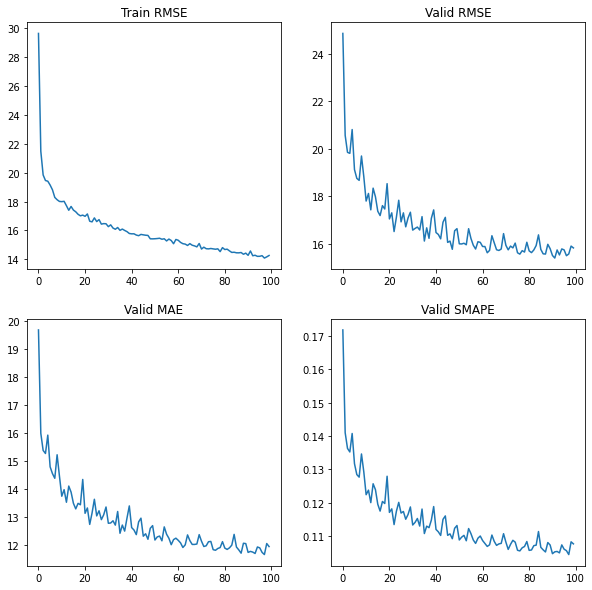

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')